In [3]:
import unidecode
import string
import random
import re
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
from fastDamerauLevenshtein import damerauLevenshtein

In [4]:
sequences = unidecode.unidecode(open('data/text_prediction_data_2022-04-19.txt').read())
file_len = len(sequences)

In [5]:
data_split = sequences.splitlines()

In [6]:
all_chars = string.printable
n_characters = len(all_chars)

In [7]:
all_chars = ''.join(set(sorted(sequences)))
all_chars

'mhtfbyqirncake\nowxuzpdsvg'

In [8]:
chunk_len = 500

In [9]:
def generate_random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return sequences[start_index:end_index]

In [10]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [11]:
def convert_char_to_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_chars.index(string[c])
    return Variable(tensor)

In [12]:
def generate_random_training_set():    
    chunk = generate_random_chunk()
    inp = convert_char_to_tensor(chunk[:-1])
    target = convert_char_to_tensor(chunk[1:])
    return inp, target

In [13]:
def evaluate_prediction(prime_str='\n', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = convert_char_to_tensor(prime_str)
    #print(prime_input)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        #print(top_i)
        
        # Add predicted character to string and use as next input
        #print(len(all_chars))
        predicted_char = all_chars[top_i]
        #print(predicted_char)
        predicted += predicted_char
        inp = convert_char_to_tensor(predicted_char)
        #print(inp)

    return predicted

In [14]:
def time_elapsed_since(start_time):
    seconds = time.time() - start_time
    minutes = math.floor(seconds / 60)
    seconds -= minutes * 60
    return '%dm %ds' % (minutes, seconds)

In [15]:
def train_model(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len - 1):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, torch.LongTensor([target[c]]))

    loss.backward()
    decoder_optimizer.step()

    return loss.data / chunk_len

In [19]:
evaluate_prediction('po', 6, temperature=0.4)

'pocwg\npw'

### Train model + evaluate loss

In [17]:
n_epochs = 300
print_every = 150
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers=n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train_model(*generate_random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_elapsed_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate_prediction('po', 10), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 37s (150 50%) 1.0384]
pococog
pwkf 

 14s (300 100%) 0.3280]
pocwgrk
pwtn 



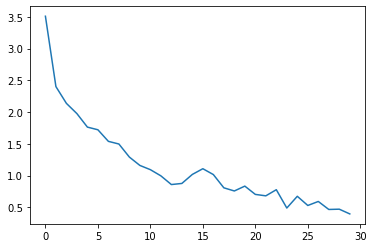

In [18]:
plt.figure()
plt.plot(all_losses)

In [20]:
def get_prequential_error(data_split):

    results = [[] for line in data_split]
    errors = [[] for x in data_split]

    for line in range(0, len(data_split)):
        i = 0
    
        while i < len(data_split[line]) - 1:
        #print(data_split[line])
            if i == 0:
                # generate prediction for first char (input: newline character)
                first_char = evaluate_prediction('\n', 1, temperature=0.4)
                predicted = first_char[1]
                observed = data_split[line][i]
                #print(predicted, observed)
                error = 1 - damerauLevenshtein(predicted, observed)
                errors[line].append(error)
                i += 1
            
            else:    
                # generate prediction for next char (input: current char)
                next_char = evaluate_prediction(data_split[line][i-1], 1, temperature=0.4)
                predicted = next_char[1]
                observed = data_split[line][i]
                #print(predicted, observed)
                error = 1 - damerauLevenshtein(predicted, observed)
                errors[line].append(error)
                i += 1
    
    return errors

In [21]:
errors = get_prequential_error(data_split)

In [22]:
summed_error = [sum(error) for error in errors]
np.median(summed_error)

5.0

In [23]:
with open('results/pytorch_rnn_prequential_summed_2022-04-19.txt', 'w') as f:
    f.write(str(summed_error))